In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
icu_stay_df = pd.read_csv("./temp_pp_data_files/icu_stay_drugs.csv")
chart_events = pd.read_csv("./temp_pp_data_files/CHARTEVENTS_2.csv")
item_df = pd.read_csv("../V1.1.0/D_ITEMS.csv")

In [3]:
events_by_hadm = chart_events.groupby('ITEMID')['HADM_ID'].nunique()
# side note: there are 13449 different HADMs in the dataset
# at least 50% to get some meaningful values like blood pressure, heart rate
most_common_events = events_by_hadm.loc[(events_by_hadm / 13449) > 0.60]
# which values are common?
idx_lst = most_common_events.index.to_list()
# D_ITEM has multiple ITEMIDs with str dtype, so convert the index list to string first to search for those IDs
idx_lst = map(str, idx_lst)
id_to_name_grp = item_df.query('ITEMID in @idx_lst').groupby('ITEMID')['LABEL']
id_to_name = id_to_name_grp.apply(lambda grp: list(grp.value_counts().index)[0]).to_dict()

In [4]:
# calc upper outer fence: turkeys method boxplot (marks border between possible and actual outliers) 
# --> useful for winsorizing
def uo_fence(df):    
    q1 = df["VALUENUM"].quantile(0.25)
    q3 = df["VALUENUM"].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    return outer_fence_ue, outer_fence_le

In [5]:
# calculate upper and lower fence per column
upper_fences = {}
lower_fences = {}
for chart_val_id in list(id_to_name.keys()):
    chart_val_only_df_mask = chart_events["ITEMID"] == int(chart_val_id)
    fence_up, fence_low = uo_fence(chart_events.loc[chart_val_only_df_mask])
    fence_up, fence_low = round(fence_up, 2), round(fence_low, 2)
    upper_fences[chart_val_id] = fence_up
    lower_fences[chart_val_id] = fence_low

In [6]:
# calculate closest upper quantile for upper fence
k_dict_up = {}
for chart_val_id in upper_fences:
    chart_val_only_df_mask = chart_events["ITEMID"] == int(chart_val_id)
    vals_only_df = chart_events.loc[chart_val_only_df_mask]
    quant_90 = vals_only_df["VALUENUM"].quantile(0.90)
    quant_925 = vals_only_df["VALUENUM"].quantile(0.925)
    quant_95 = vals_only_df["VALUENUM"].quantile(0.95)
    quant_975 = vals_only_df["VALUENUM"].quantile(0.975)
    quant_99 = vals_only_df["VALUENUM"].quantile(0.99)
    tmp_lst = [quant_90, quant_925, quant_95, quant_975, quant_99]
    closest_idx = (np.abs(tmp_lst - upper_fences[chart_val_id])).argmin()
    k_dict_up[chart_val_id] = round(tmp_lst[closest_idx],2)

In [7]:
# calculate closest lower quantile for lower fence
k_dict_low = {}
for chart_val_id in lower_fences:
    chart_val_only_df_mask = chart_events["ITEMID"] == int(chart_val_id)
    vals_only_df = chart_events.loc[chart_val_only_df_mask]
    quant_10 = vals_only_df["VALUENUM"].quantile(0.10)
    quant_075 = vals_only_df["VALUENUM"].quantile(0.075)
    quant_05 = vals_only_df["VALUENUM"].quantile(0.05)
    quant_025 = vals_only_df["VALUENUM"].quantile(0.025)
    quant_01 = vals_only_df["VALUENUM"].quantile(0.01)
    tmp_lst = [quant_01, quant_025, quant_05, quant_075, quant_10]
    closest_idx = (np.abs(tmp_lst - lower_fences[chart_val_id])).argmin()
    k_dict_low[chart_val_id] = round(tmp_lst[closest_idx],2)

In [8]:
# winsorize each column
for chart_id in id_to_name.keys():
    chart_events.loc[(chart_events["ITEMID"].eq(int(chart_id))) & (chart_events["VALUENUM"] > k_dict_up[chart_id]), 'VALUENUM'] = k_dict_up[chart_id]
    chart_events.loc[(chart_events["ITEMID"].eq(int(chart_id))) & (chart_events["VALUENUM"] < k_dict_low[chart_id]) & (chart_events["VALUENUM"] != np.nan), 'VALUENUM'] = k_dict_low[chart_id] if k_dict_low[chart_id] > 0 else 0 
# winsorize each column
#for col_name in col_names:
#    icu_stay_df[col_name].values[icu_stay_df[col_name] > k_dict_up[col_name]] = k_dict_up[col_name]
#    # no negative values possible
#    icu_stay_df[col_name].values[(icu_stay_df[col_name] < k_dict_low[col_name]) & (icu_stay_df[col_name] != np.nan)] = k_dict_low[col_name] if k_dict_low[col_name] > 0 else 0 
    


In [9]:
events_by_hadm = chart_events.groupby('ITEMID')['HADM_ID'].nunique()

In [10]:
# side note: there are 13449 different HADMs in the dataset
# at least 50% to get some meaningful values like blood pressure, heart rate
most_common_events = events_by_hadm.loc[(events_by_hadm / 13449) > 0.60]

In [12]:
# which values are common?
idx_lst = most_common_events.index.to_list()
# D_ITEM has multiple ITEMIDs with str dtype, so convert the index list to string first to search for those IDs
idx_lst = map(str, idx_lst)
id_to_name_grp = item_df.query('ITEMID in @idx_lst').groupby('ITEMID')['LABEL']

In [13]:
id_to_name = id_to_name_grp.apply(lambda grp: list(grp.value_counts().index)[0]).to_dict()

In [14]:
id_to_name

{'1001': 'Temperature',
 '1003': 'Heart Rate',
 '1004': 'Respiratory Rate',
 '1007': 'Excrement',
 '1015': 'Diastolic Pressure',
 '1016': 'Systolic Pressure'}

In [15]:
for item_id in list(id_to_name.keys()):
    event_name = id_to_name[item_id]
    # ids are ints in icu_stay_df
    item_id = int(item_id)
    kwargs_dict = {f'{event_name}_min': ('VALUENUM', np.min), f'{event_name}_max': ('VALUENUM', np.max), f'{event_name}_avg': ('VALUENUM', np.nanmean)}
    chart_events_df_temp = chart_events[chart_events['ITEMID'] == item_id]
    max_event_value_per_hadm = chart_events_df_temp.groupby("HADM_ID").agg(**kwargs_dict)
    for col in kwargs_dict.keys():
        hadm_id_to_col = {hadm_id: col for hadm_id, col in zip(max_event_value_per_hadm.index, max_event_value_per_hadm[col])}
        icu_stay_df[col] = icu_stay_df['HADM_ID'].map(hadm_id_to_col)
        # round avg column: 10,12345 -> 10,12
        if col.endswith("_avg"):
            icu_stay_df[col] = icu_stay_df[col].round(2)

# Check outlier

In [16]:
col_prefixes =[event for event in id_to_name.values()]

col_names = [event_val + suffix for event_val in col_prefixes for suffix in ["_min", "_max"]]

In [17]:
min_max_columns = icu_stay_df[col_names]

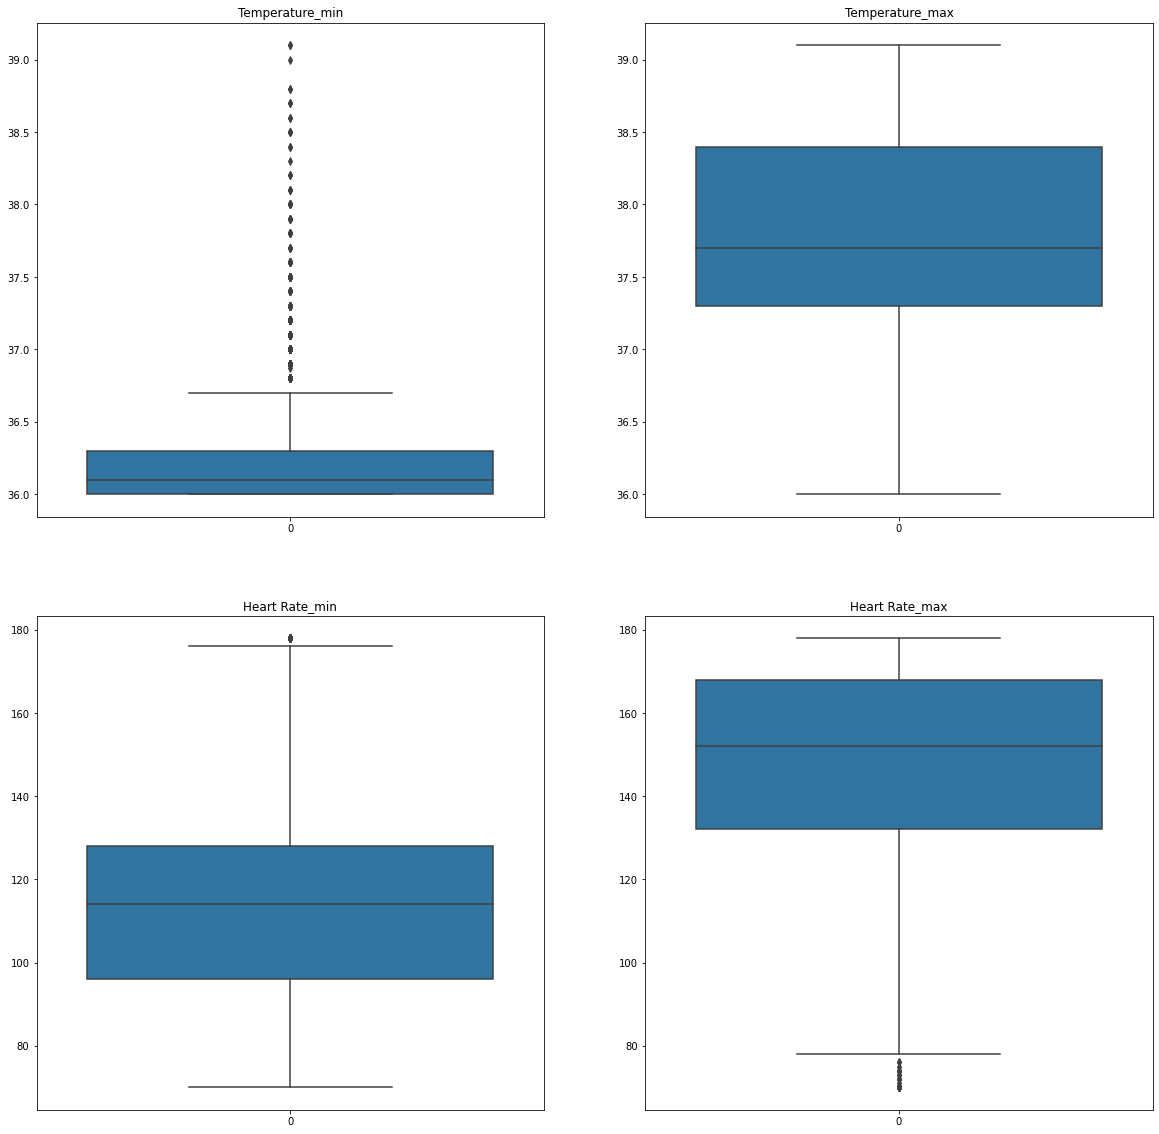

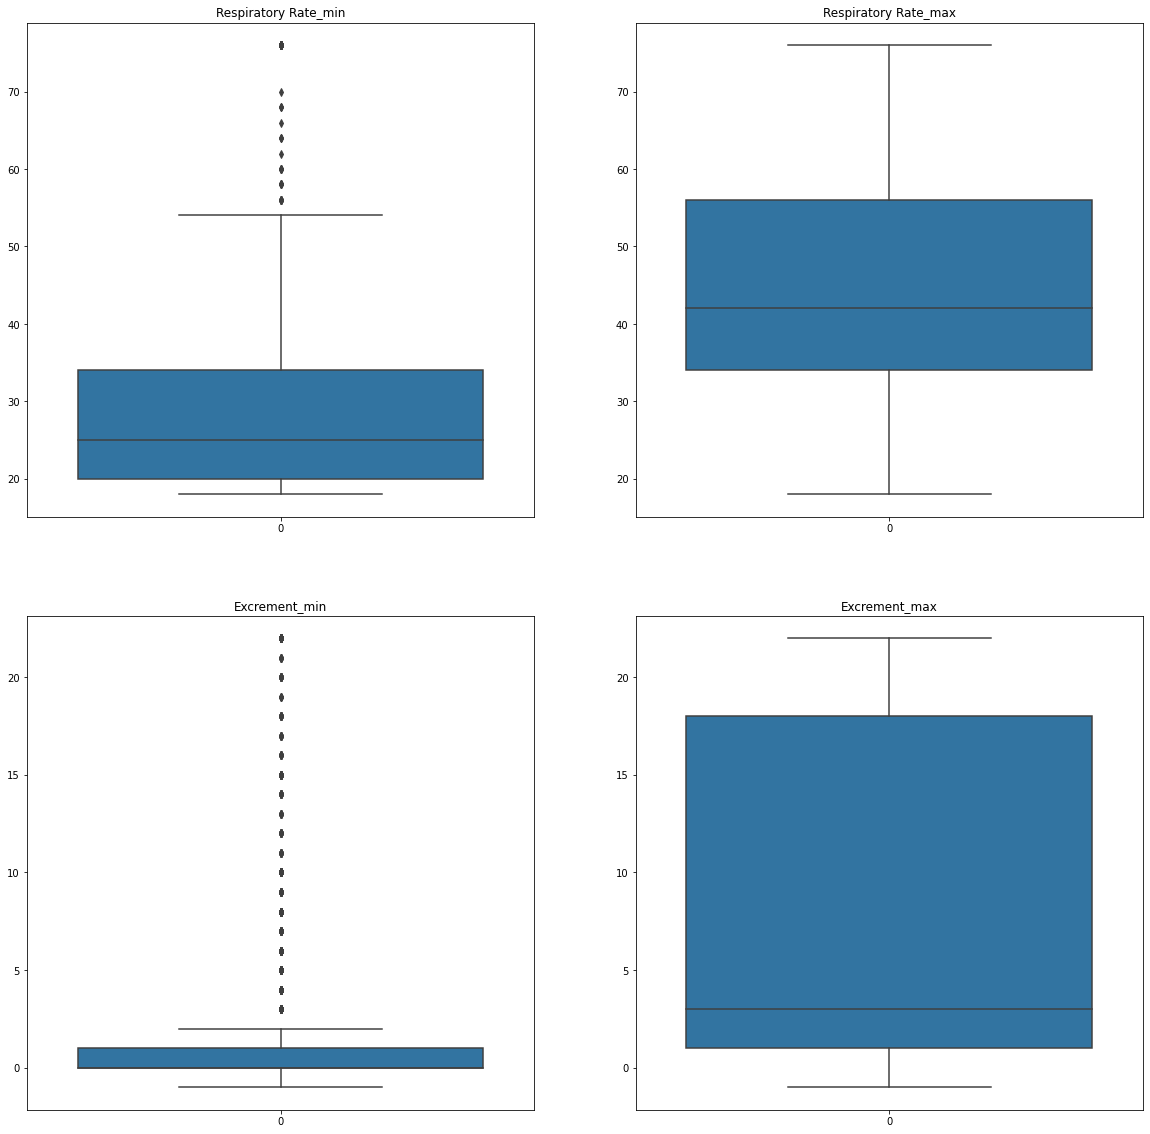

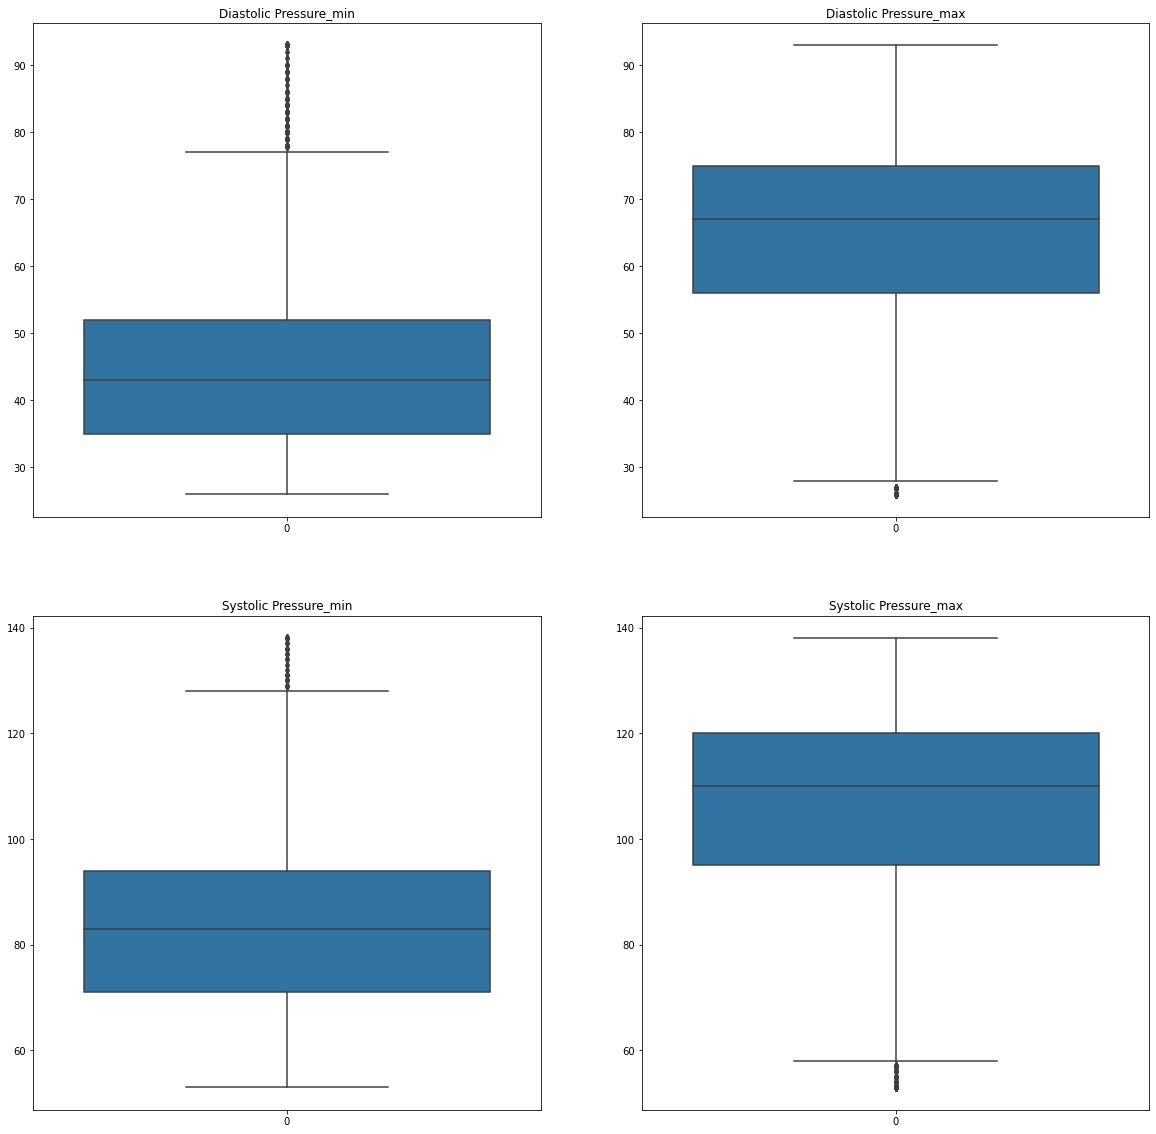

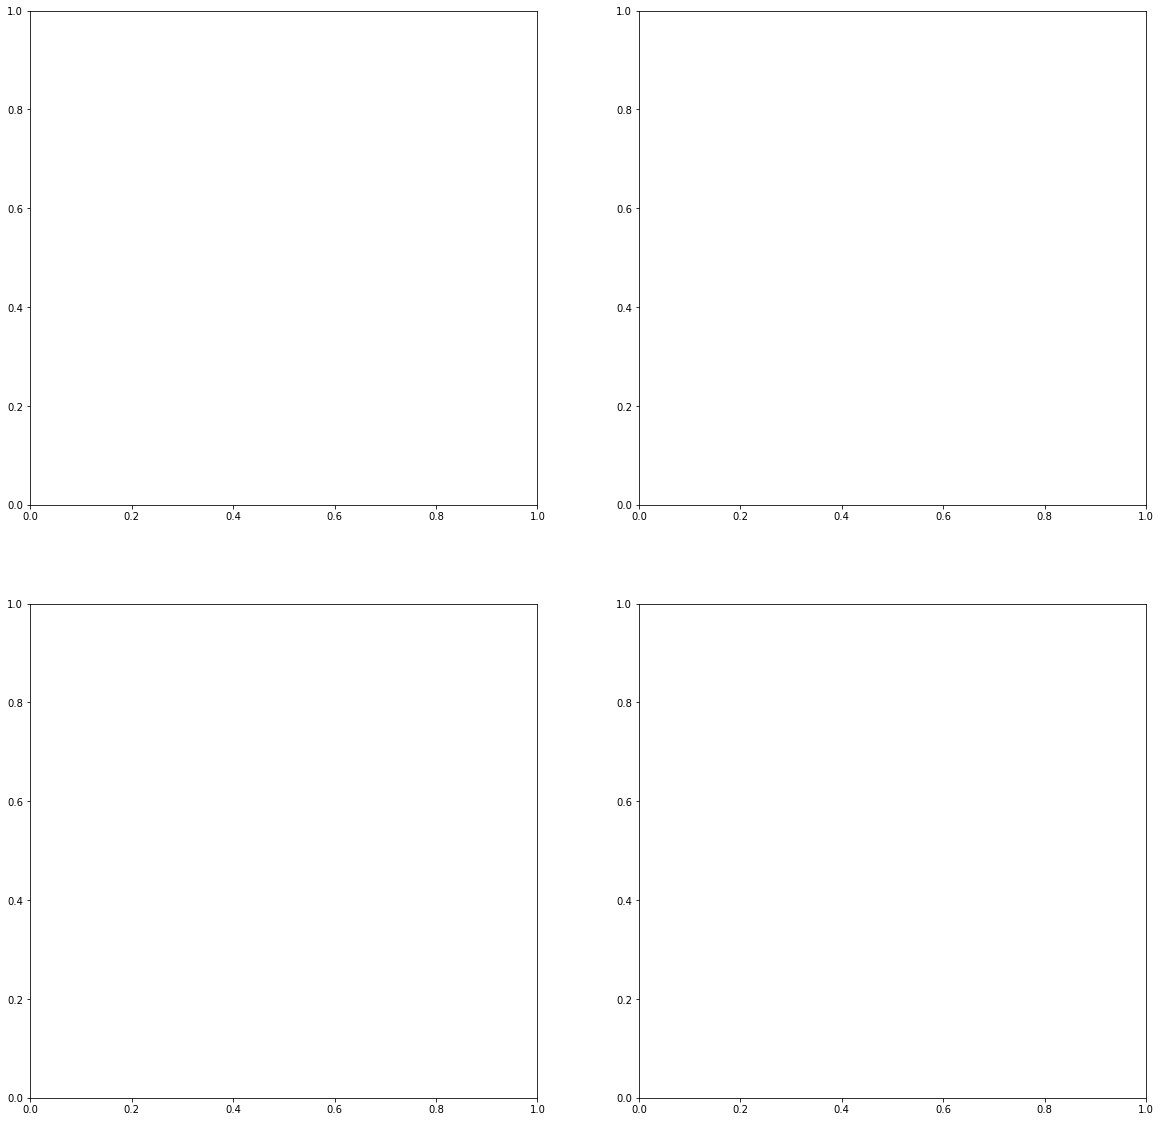

In [18]:
min_max_columns = icu_stay_df[col_names]
for i in range(4):
    data = min_max_columns.iloc[:,i*4: (i+1)*4]
    fig3, axes3 = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
    for name, ax in zip(data.columns, axes3.flatten()):
        sns.boxplot(data=data[name], orient='v', ax=ax)
        ax.set_title(name)
        # add a horizontal line, which marks the actual outer upper fence for this feature
        

### Winsorizing was successfull in removing extreme outliers

In [20]:
icu_stay_df.to_csv("./temp_pp_data_files/icustay_chart_events.csv", index=False)